## In this notebook will rebuild Thomas Schelling's classic model of housing segregation. The original paper can be found [here](https://www.uzh.ch/cmsssl/suz/dam/jcr:00000000-68cb-72db-ffff-ffffff8071db/04.02_schelling_71.pdf).

Tutorial by Antonio Sirianni. 

In [1]:
import re
import time
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## 1. Set up simulation parameters

In [2]:
N_GROUP = 12
GRID_X = 8
GRID_Y = 6

## 2. BUILD THE NEIGHBORHOOD
We will use a network structure to keep track of the pattern of spots in the neighborhood 'neighbor' relations.

In [3]:
def latticify(gridwidth, gridlength, diagonals = True):
    lots = gridwidth * gridlength
    Neighborhood = nx.Graph()
    xcoord ={}
    ycoord ={}
    residents = {}
    for x in range(0,lots):
        Neighborhood.add_node(x)
        ycoord[x] = int(x/gridlength)
        xcoord[x] = x%gridlength
        residents[x] = None
    nx.set_node_attributes(Neighborhood,'xcoord',xcoord)
    nx.set_node_attributes(Neighborhood,'ycoord',ycoord)
    nx.set_node_attributes(Neighborhood,'residents',residents)
    #print xcoord
    ##This double loop will add edges between any two neighbors in the neighboorhood
    #print Neighborhood[6]
    for a in range(0,lots):
        for b in range(0,lots):
            if a > b:
                h_dist = abs(Neighborhood.node[a]['xcoord'] - Neighborhood.node[b]['xcoord'])
                v_dist = abs(Neighborhood.node[a]['ycoord'] - Neighborhood.node[b]['ycoord'])
                if h_dist + v_dist == 1:
                    Neighborhood.add_edge(a,b)
                elif (h_dist == 1) & (v_dist ==1):
                    if diagonals ==True:
                        Neighborhood.add_edge(a,b)
    return Neighborhood

We can call the function here to check the neighborhood:

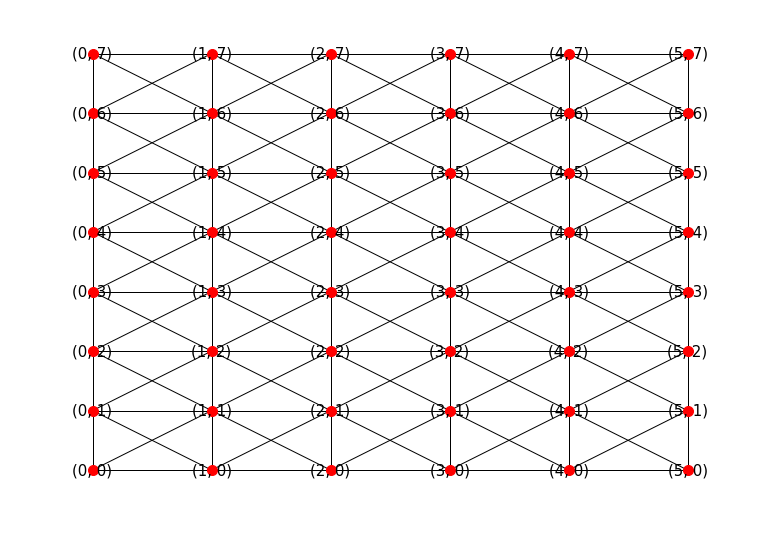

In [6]:
N = latticify(GRID_X, GRID_Y, diagonals = True)
label_value_dict = {}
pos = {}
plt.figure(figsize=(10,7))
for q in nx.nodes(N):
    label_value_dict[q]= (N.node[q]['xcoord'],N.node[q]['ycoord'])
    pos[q]=[q%6/float(8),int(q/6)/float(8)]
nx.draw(N,pos,font_size = 15,labels = label_value_dict,node_size = 100)

plt.show()

## 3. BUILD THE NEIGHBORS, RANDOMLY GIVE THEM A SPOT IN THE NEIGHBORHOOD

In [7]:
class neighbor:
    def __init__(self,neighbor_id,color,in_group,out_group,home):
        self.id = neighbor_id
        self.color = color
        self.in_group = in_group
        self.out_group = out_group
        self.home = home
    def move(self,new_location):
        self.home = new_location

In [8]:
Neighbors = []

InitialHomes = np.random.choice(range(48), size=2*N_GROUP, replace=False)

InitialXHomes = InitialHomes[:N_GROUP] # first N
InitialYHomes = InitialHomes[N_GROUP:] # last N

for idx, home in enumerate(InitialHomes):
    N.node[home]['residents']=idx
    if idx < N_GROUP:
        Neighbors.append(neighbor(idx,'blue',0.4,0.0,home))
    else:
        Neighbors.append(neighbor(idx,'green',0.4,0.0,home))

# N = latticify(8,6,diagonals = True)
color_value_dict = {}
for q, attr in N.nodes_iter(data=True):
    resident = attr['residents']
    if resident != None:
        if Neighbors[resident].color == 'blue':
            color_value_dict[q]= 'blue'
        elif Neighbors[resident].color == 'green':
            color_value_dict[q] ='green'
    else:
        color_value_dict[q] = 'white'

## 4. CHECK THE POPULATED NEIGHBORHOOD

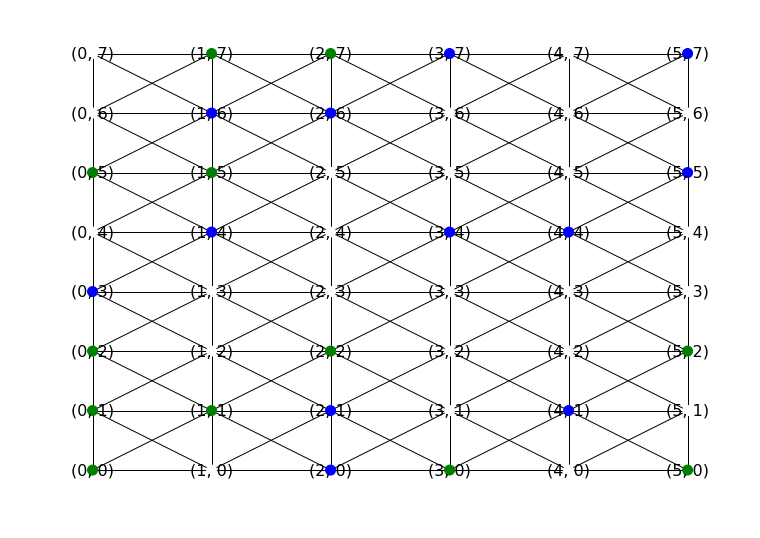

In [9]:
plt.figure(figsize=(10,7))
color_value = [color_value_dict.get(node) for node in N.nodes()]
nx.draw(N,pos,font_size = 16,labels = label_value_dict,node_size = 100,node_color = color_value)
plt.show()

## 5. BUILD FUNCTION THAT MEASURES SEGREGATION

Schelling uses two measures of segregation:

1. The average over all agents of the ratio $\frac{similar}{different}$
1. The number of agents whose 8 nearest neighbors all have the same label

We use two simple(er?) measures:
1. The fraction of same-group neighbors, averaged over each individual: $\sum_i \frac{similar_i}{neighbors_i}$
2. The fraction of same-group edges, $\frac{\#similar}{\#edges}$

In [14]:
def measure_segregation(network, neighbors):
    """
    This function returns both segregation measures
    Ego segregation, then edge segregation
    """
    
    accepted_colors = {'blue', 'green'}
    
    ego_network_similarity = []
    
    # Iterate through individuals
    for coord_idx, attr in network.nodes_iter(data=True):
        resident = attr['residents']
        if resident != None:
            ego_color = neighbors[resident].color
            similar_count = 0
            neighbor_count = 0
            ego_g = nx.ego_graph(network, coord_idx)
            ego_g.remove_node(coord_idx) # delete ego, only alters remain
            for _, alter_attr in ego_g.nodes_iter(data=True):
                alter_resident = alter_attr['residents']
                if alter_resident != None:
                    alter_color = neighbors[alter_resident].color
                    if ego_color == alter_color:
                        similar_count += 1
                    neighbor_count += 1
            try:
                ego_network_similarity.append(similar_count / neighbor_count)
            except ZeroDivisionError:
                continue
    
    # Iterate through edges
    similar_ties = 0
    all_ties = 0
    for n1, n2 in network.edges_iter():
        res1 = network.node[n1]['residents']
        res2 = network.node[n2]['residents']
        if res1 != None and res2 != None:
            res1_color = neighbors[res1].color
            res2_color = neighbors[res2].color
            if res1_color == res2_color:
                similar_ties += 1
            all_ties += 1
    
    return np.mean(ego_network_similarity), similar_ties / all_ties

In [15]:
measure_segregation(N, Neighbors)

(0.21739130434782608, 0)

## 6. BUILD LOOP THAT MOVES THE NEIGHBORS AROUND

## First build functions that check desirability of locations for neighbors

In [16]:
def checkoldspot(neighbor,allneighbors,theneighborhood):
    neighbor_outgroup_pref = neighbor.out_group
    neighbor_ingroup_pref = neighbor.in_group
    in_group_neighbors = 0
    out_group_neighbors = 0
    neighbor_lots = theneighborhood.neighbors(neighbor.id)
    the_neighbors = []
    for t in neighbor_lots:
        a_neighbor = theneighborhood.node[t]['residents']
        if a_neighbor != None:
            the_neighbors.append(a_neighbor)
    #print the_neighbors
    for u in the_neighbors:
        if allneighbors[u].color == neighbor.color:
            in_group_neighbors = in_group_neighbors + 1
        else:
            out_group_neighbors = out_group_neighbors + 1
    if (in_group_neighbors/float(in_group_neighbors+out_group_neighbors+.001)) >= neighbor_ingroup_pref:
        if (out_group_neighbors/float(in_group_neighbors+out_group_neighbors+.001)) >= neighbor_outgroup_pref:
            good_spot = True
        else:
            good_spot = False
    else:
        good_spot = False
    return good_spot

def checknewspot(neighbor,newspot,allneighbors,theneighborhood):
    if theneighborhood.node[newspot]['residents'] == None:
        neighbor_outgroup_pref = neighbor.out_group
        neighbor_ingroup_pref = neighbor.in_group
        in_group_neighbors = 0
        out_group_neighbors = 0
        current_in_group_neighbors = 0
        current_out_group_neighbors = 0
        neighbor_lots = theneighborhood.neighbors(newspot)
        the_neighbors = []
        for t in neighbor_lots:
            a_neighbor = theneighborhood.node[t]['residents']
            if a_neighbor != None:
                the_neighbors.append(a_neighbor)
        #print the_neighbors
        for u in the_neighbors:
            if allneighbors[u].color == neighbor.color:
                in_group_neighbors = in_group_neighbors + 1
            else:
                out_group_neighbors = out_group_neighbors + 1
        #Get old spots for comparison
        currentneighbor_lots = theneighborhood.neighbors(neighbor.id)
        current_neighbors = []
        for s in currentneighbor_lots:
            a_cur_neighbor = theneighborhood.node[s]['residents']
            if a_cur_neighbor != None:
                current_neighbors.append(a_cur_neighbor)
        #print the_neighbors
        for r in current_neighbors:
            if allneighbors[r].color == neighbor.color:
                current_in_group_neighbors = current_in_group_neighbors + 1
            else:
                current_out_group_neighbors = current_out_group_neighbors + 1
        if ((in_group_neighbors/float(in_group_neighbors+out_group_neighbors+.001)) >= neighbor_ingroup_pref) & ((out_group_neighbors/float(in_group_neighbors+out_group_neighbors+.001)) >= neighbor_outgroup_pref):
            good_spot = True
        else:
            ing_improve = (in_group_neighbors/float(in_group_neighbors+out_group_neighbors+.001)) > min((current_in_group_neighbors/float(current_in_group_neighbors+current_out_group_neighbors+.001),neighbor_ingroup_pref))
            og_improve = (out_group_neighbors/float(in_group_neighbors+out_group_neighbors+.001)) > min((current_out_group_neighbors/float(current_in_group_neighbors+current_out_group_neighbors+.001),neighbor_ingroup_pref))
            good_spot = ing_improve and og_improve
    else:
        good_spot = False
    return good_spot

TODO: What is this next step doing?

In [17]:
Num_Of_Moves = 10000
Actual_Moves = 0
for t in range(0,Num_Of_Moves):
    Mover = Neighbors[random.randint(0,23)]
    if checkoldspot(Mover,Neighbors,N) == False:
        NewDigs = random.randint(0,47)
        if checknewspot(Mover,NewDigs,Neighbors,N) == True:
            OldDigs = Mover.home
            N.node[OldDigs]['residents'] = None
            N.node[NewDigs]['residents'] = Mover.id
            Mover.move(NewDigs)
            Actual_Moves = Actual_Moves + 1

print(Actual_Moves)

color_value_dict = {}

for q in nx.nodes(N):
    resident = N.node[q]['residents']
    #print resident
    try:
        if Neighbors[int(resident)].color == 'blue':
            color_value_dict[q]= 'blue'
        elif Neighbors[int(resident)].color == 'green':
            color_value_dict[q] ='green'
        else:
            color_value_dict[q] = 'white'
    except:
        color_value_dict[q] = 'white'

919


## 7. CHECK THE SHIFTED NEIGHBORHOOD

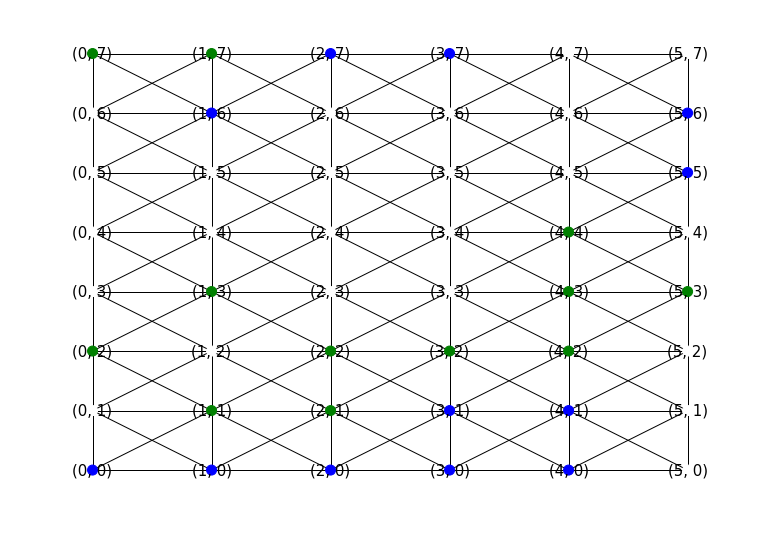

(0.29166666666666669, 0)

In [18]:

color_value = [color_value_dict.get(node) for node in N.nodes()]
plt.figure(figsize=(10,7))
nx.draw(N,pos,font_size = 15,labels = label_value_dict,node_size = 100,node_color = color_value)
plt.show()

measure_segregation(N,Neighbors)

## 8. BUILD FUNCTION THAT DOES ALL OF THIS SO YOU CAN ITERATE THROUGH A PARAMETER SPACE

In [19]:
def schellify(Rows,Columns,BlueResidents,BlueIGP,BlueOGP,GreenResidents,GreenIGP,GreenOGP,Moves,Diagonal = True,ShowPlot = False):
    #Build a Neighborhood
    TheNeighborhood = latticify(Columns, Rows, diagonals = Diagonal)
    #Fill it with Neighbors
    TheNeighbors = []
    for x in range(0,BlueResidents):
        NewHome = None
        while NewHome == None:
            PotentialHome = random.randint(0,Rows*Columns-1)
            if TheNeighborhood.node[PotentialHome]['residents']==None:
                TheNeighborhood.node[PotentialHome]['residents']=x
                NewHome = PotentialHome
            else:
                pass
        TheNeighbors.append(neighbor(x,'blue',BlueIGP,BlueOGP,NewHome))
    for y in range(BlueResidents,BlueResidents+GreenResidents):
        NewHome = None
        while NewHome == None:
            PotentialHome = random.randint(0,Rows*Columns-1)
            if TheNeighborhood.node[PotentialHome]['residents']==None:
                TheNeighborhood.node[PotentialHome]['residents']=y
                NewHome = PotentialHome
            else:
                pass
        TheNeighbors.append(neighbor(y,'green',GreenIGP,GreenOGP,NewHome))
    init_ego_seg, init_edge_seg = measure_segregation(TheNeighborhood, TheNeighbors)
    #Let the Neighbors Move Around
    Actual_Moves = 0
    for m in range(0,Moves):
        Mover = TheNeighbors[random.randint(0,BlueResidents+GreenResidents-1)]
        if checkoldspot(Mover,TheNeighbors,TheNeighborhood) == False:
            NewDigs = random.randint(0,Rows*Columns-1)
            if checknewspot(Mover,NewDigs,TheNeighbors,TheNeighborhood) == True:
                OldDigs = Mover.home
                TheNeighborhood.node[OldDigs]['residents'] = None
                TheNeighborhood.node[NewDigs]['residents'] = Mover.id
                Mover.move(NewDigs)
                Actual_Moves = Actual_Moves + 1
            else:
                pass
        else:
            pass
    #Measure Segregation of the Shuffled Neighborhood and Return Results
    if ShowPlot == True:
        label_value_dict = {}
        pos = {}
        for q in nx.nodes(TheNeighborhood):
            label_value_dict[q]= q
            pos[q]=[int(q/Rows)/float(Rows),q%Columns/float(Columns)]
        color_value_dict = {}
        for q in nx.nodes(TheNeighborhood):
            resident = TheNeighborhood.node[q]['residents']
            #print resident
            try:
                if TheNeighbors[int(resident)].color == 'blue':
                    color_value_dict[q]= 'blue'
                elif TheNeighbors[int(resident)].color == 'green':
                    color_value_dict[q] ='green'
                else:
                    color_value_dict[q] = 'white'
            except:
                color_value_dict[q] = 'white'
        color_value = [color_value_dict.get(node) for node in TheNeighborhood.nodes()]

        nx.draw(TheNeighborhood,pos,font_size = 5,labels = label_value_dict,node_size = 100,node_color = color_value)
        plt.show()
    else:
        pass
    post_ego_seg,post_edge_seg = measure_segregation(TheNeighborhood, TheNeighbors)
    return init_ego_seg, init_edge_seg, Actual_Moves, post_ego_seg, post_edge_seg

## 9. USE FUNCTION TO LOOP THROUGH PARAMETER SPACE

In [ ]:
for x in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]:
    for y in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]:
        for z in range(0,10):
            a,b,c,d,e = schellify(8,8,25,x,y,25,x,y,10000)
            print('params {}|{}|{} had {} ego segregation and {} network segregation'.format(
                x, y, z, round(d, 3), round(e, 3)
            ))

params 0|0|0 had 0.02 ego segregation and 0.0 network segregation
params 0|0|1 had 0.12 ego segregation and 0.0 network segregation
params 0|0|2 had 0.04 ego segregation and 0.0 network segregation
params 0|0|3 had 0.06 ego segregation and 0.0 network segregation
params 0|0|4 had 0.02 ego segregation and 0.0 network segregation
params 0|0|5 had 0.04 ego segregation and 0.0 network segregation
params 0|0|6 had 0.04 ego segregation and 0.0 network segregation
params 0|0|7 had 0.0 ego segregation and 0.0 network segregation
params 0|0|8 had 0.08 ego segregation and 0.0 network segregation
params 0|0|9 had 0.02 ego segregation and 0.0 network segregation
params 0|0.1|0 had 0.04 ego segregation and 0.0 network segregation
params 0|0.1|1 had 0.0 ego segregation and 0.0 network segregation
params 0|0.1|2 had 0.0 ego segregation and 0.0 network segregation
params 0|0.1|3 had 0.02 ego segregation and 0.0 network segregation
params 0|0.1|4 had 0.04 ego segregation and 0.0 network segregation
par

In [89]:
#TODO: Perhaps it would be useful to show visualizations of some of the different outcomes (e.g. high seg, low seg)